
=== Métricas de performance ===
algorithm  elapsed_time_sec  memory_usage_mb  cpu_user_time_sec  cpu_system_time_sec  num_itemsets
  Apriori         15.867724        -3.031250          13.593750             1.984375           346
FP‑Growth         12.870579         0.859375          12.468750             1.187500           346
    ECLAT          2.864458        -1.285156           2.421875             0.296875           346

Resultados guardados en archivos .xlsx.


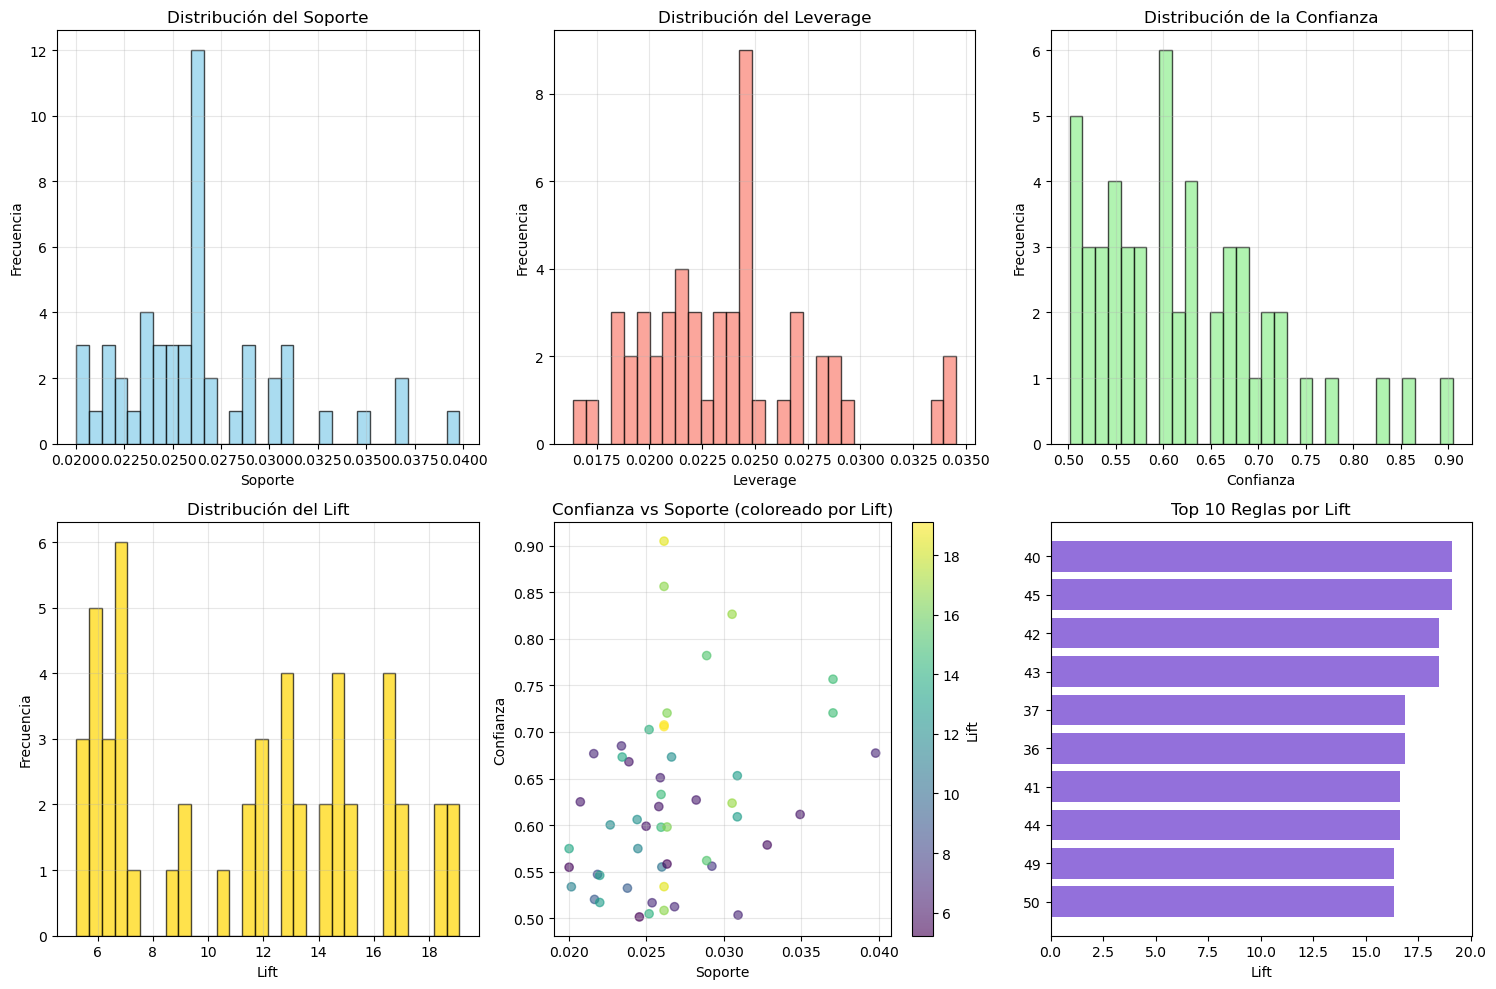


Resumen Estadístico de las Reglas de Asociación:

Número total de reglas: 51

Estadísticas de las métricas principales:
         support  confidence       lift
count  51.000000   51.000000  51.000000
mean    0.026492    0.621226  11.365976
std     0.004380    0.094284   4.435004
min     0.020021    0.501478   5.226060
25%     0.023832    0.550957   6.708248
50%     0.026003    0.605988  12.028865
75%     0.028560    0.674954  14.712801
max     0.039801    0.904841  19.097068


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Script para extraer frequent itemsets con Apriori, FP‑Growth y ECLAT,
y medir performance de cada algoritmo.
"""

# Requerimientos:
# pip install pandas mlxtend psutil openpyxl

import pandas as pd
import time
import os
import psutil

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth

# --------------------------
# 1. CARGA Y PREPROCESADO
# --------------------------

# Ajusta el nombre de archivo si es necesario
DATA_FILE = 'dataset.xlsx'

# Cargar dataset
df = pd.read_excel(DATA_FILE)

# Excluir devoluciones o cantidades negativas
df = df[df['Quantity'] > 0]

# Agrupar transacciones por número de factura
transactions = df.groupby('InvoiceNo')['Description'].apply(list).tolist()

# Limpiar transacciones: eliminar NaN y convertir todo a string
transactions = [
    [str(item) for item in trans if pd.notnull(item)]
    for trans in transactions
]

# One‑hot encode de las transacciones
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

# --------------------------
# 2. MÉTODO DE MEDICIÓN
# --------------------------

def measure_algorithm(func, df_encoded, **kwargs):
    """
    Ejecuta la función func(df_encoded, **kwargs),
    y mide tiempo, uso de memoria y CPU antes y después.
    Devuelve (resultado, métricas).
    """
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss
    cpu_before = process.cpu_times()
    start = time.time()
    
    result = func(df_encoded, **kwargs)
    
    elapsed = time.time() - start
    cpu_after = process.cpu_times()
    mem_after = process.memory_info().rss

    metrics = {
        'elapsed_time_sec': elapsed,
        'memory_usage_mb': (mem_after - mem_before) / (1024 * 1024),
        'cpu_user_time_sec': cpu_after.user - cpu_before.user,
        'cpu_system_time_sec': cpu_after.system - cpu_before.system,
        'num_itemsets': result.shape[0]
    }
    return result, metrics

# --------------------------
# 3. APRIORI
# --------------------------

min_support = 0.02  # umbral de soporte mínimo

apriori_df, apriori_metrics = measure_algorithm(
    apriori,
    df_te,
    min_support=min_support,
    use_colnames=True
)

# --------------------------
# 4. FP‑GROWTH
# --------------------------

fpgrowth_df, fpgrowth_metrics = measure_algorithm(
    fpgrowth,
    df_te,
    min_support=min_support,
    use_colnames=True
)

# --------------------------
# 5. ECLAT (implementación manual)
# --------------------------

def eclat(df_encoded, min_support):
    """
    Implementación de ECLAT:
    - Construye tidsets verticales
    - Recurso recursivo para generar itemsets frecuentes
    """
    n_trans = df_encoded.shape[0]
    support_count = min_support * n_trans

    # Tidsets iniciales para cada item individual
    tidsets = {
        item: set(df_encoded.index[df_encoded[item]])
        for item in df_encoded.columns
        if df_encoded[item].sum() >= support_count
    }

    freq_items = []

    def recursive(prefix, items, tidsets_local):
        for i, item in enumerate(items):
            new_prefix = prefix + [item]
            new_tid = tidsets_local[item]
            support = len(new_tid) / n_trans
            freq_items.append((new_prefix, support))
            # Construir sufijos
            suffix_items = items[i+1:]
            new_tidsets = {}
            for other in suffix_items:
                inter = new_tid & tidsets_local[other]
                if len(inter) >= support_count:
                    new_tidsets[other] = inter
            if new_tidsets:
                recursive(new_prefix, list(new_tidsets.keys()), new_tidsets)

    recursive([], list(tidsets.keys()), tidsets)

    # Convertir a DataFrame
    patterns = pd.DataFrame([
        {'itemsets': set(itemset), 'support': support}
        for itemset, support in freq_items
    ])
    return patterns

eclat_df, eclat_metrics = measure_algorithm(
    eclat,
    df_te,
    min_support=min_support
)

# --------------------------
# 6. RESUMEN DE MÉTRICAS
# --------------------------

metrics = pd.DataFrame([
    {'algorithm': 'Apriori',    **apriori_metrics},
    {'algorithm': 'FP‑Growth',  **fpgrowth_metrics},
    {'algorithm': 'ECLAT',      **eclat_metrics},
])

print("\n=== Métricas de performance ===")
print(metrics.to_string(index=False))

# Opcional: guardar resultados en Excel
metrics.to_excel('performance_comparison.xlsx', index=False)
apriori_df.to_excel('apriori_itemsets.xlsx', index=False)
fpgrowth_df.to_excel('fpgrowth_itemsets.xlsx', index=False)
eclat_df.to_excel('eclat_itemsets.xlsx', index=False)

print("\nResultados guardados en archivos .xlsx.")

# --- Visualización y análisis de reglas de asociación ---

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import association_rules

# Elige el algoritmo que quieres analizar (puedes cambiar apriori_df por fpgrowth_df o eclat_df)
itemsets_df = fpgrowth_df  # Cambia a apriori_df o eclat_df si lo prefieres

# Generar reglas de asociación
rules = association_rules(itemsets_df, metric="confidence", min_threshold=0.5)

# Calcular métricas adicionales
rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])
rules['conviction'] = rules.apply(lambda x: 
    (1 - x['consequent support']) / (1 - x['confidence']) if x['confidence'] < 1 else float('inf'), axis=1)

plt.figure(figsize=(15, 10))

# 1. Distribución del soporte
plt.subplot(2, 3, 1)
plt.hist(rules['support'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución del Soporte')
plt.xlabel('Soporte')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

# 2. Distribución del leverage
plt.subplot(2, 3, 2)
plt.hist(rules['leverage'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Distribución del Leverage')
plt.xlabel('Leverage')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

# 3. Distribución de la confianza
plt.subplot(2, 3, 3)
plt.hist(rules['confidence'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribución de la Confianza')
plt.xlabel('Confianza')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

# 4. Distribución del lift
plt.subplot(2, 3, 4)
plt.hist(rules['lift'], bins=30, alpha=0.7, color='gold', edgecolor='black')
plt.title('Distribución del Lift')
plt.xlabel('Lift')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

# 5. Scatter plot: Confianza vs Soporte
plt.subplot(2, 3, 5)
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.title('Confianza vs Soporte (coloreado por Lift)')
plt.xlabel('Soporte')
plt.ylabel('Confianza')
plt.grid(True, alpha=0.3)

# 6. Top 10 reglas por lift
plt.subplot(2, 3, 6)
top_rules = rules.nlargest(10, 'lift')
plt.barh(range(len(top_rules)), top_rules['lift'], color='mediumpurple')
plt.yticks(range(len(top_rules)), [f"{str(rule)[:25]}..." if len(str(rule)) > 25 else str(rule) 
                                  for rule in top_rules.index])
plt.title('Top 10 Reglas por Lift')
plt.xlabel('Lift')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('analisis_reglas_asociacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Imprimir resumen estadístico
print("\nResumen Estadístico de las Reglas de Asociación:")
print("\nNúmero total de reglas:", len(rules))
print("\nEstadísticas de las métricas principales:")
print(rules[['support', 'confidence', 'lift']].describe())

# Guardar resultados
rules.to_excel('reglas_asociacion.xlsx', index=False)
itemsets_df.to_excel('conjuntos_frecuentes.xlsx', index=False)


## Conclusiones
Los tres algoritmos convergen en los mismos patrones de compra del dataset OnlineRetail, confirmando combinaciones estables y accionables. En itemsets frecuentes, el podio de soportes es idéntico: (1) “JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT” (3,98%), (2) “GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER” (3,71%) y (3) “JUMBO STORAGE BAG SUKI + JUMBO BAG RED RETROSPOT” (3,49%). Estos resultados se repiten en Apriori, FP-Growth y ECLAT, lo que refuerza su solidez.  
La principal diferencia funcional es que Apriori permite extraer reglas de asociación con métricas de soporte, confianza y lift, mientras que FP-Growth y ECLAT aquí se usaron para descubrir itemsets frecuentes (no reglas). Las reglas de mayor lift se concentran en la serie “Regency teacup and saucer”: por ejemplo, quien compra “PINK REGENCY TEACUP AND SAUCER” tiene alta probabilidad de llevar también las variantes “GREEN” y “ROSES”, con lifts cercanos a 19, lo que indica que ocurren muchas más veces de lo esperable por azar.  

## Tabla de resultados de los 3 algoritmos
| Algoritmo  | Tiempo (s) | Itemsets frecuentes (n) | Top 3 pares por soporte |
|---|---:|---:|---|
| Apriori | 15,87 | 346 | 1) JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT (3,98%)<br>2) GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER (3,71%)<br>3) JUMBO STORAGE BAG SUKI + JUMBO BAG RED RETROSPOT (3,49%) |
| FP-Growth | 12,87 | 346 | 1) JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT (3,98%)<br>2) GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER (3,71%)<br>3) JUMBO STORAGE BAG SUKI + JUMBO BAG RED RETROSPOT (3,49%) |
| ECLAT | **2,86** | 346 | 1) JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT (3,98%)<br>2) GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER (3,71%)<br>3) JUMBO STORAGE BAG SUKI + JUMBO BAG RED RETROSPOT (3,49%) |

**Reglas destacadas (solo Apriori, top 3 por lift)**
| Antecedente | Consecuente | Soporte | Confianza | Lift |
|---|---|---:|---:|---:|
| PINK REGENCY TEACUP AND SAUCER | GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER | 2,61% | 70,76% | 19,10 |
| GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER | PINK REGENCY TEACUP AND SAUCER | 2,61% | 70,57% | 19,10 |
| GREEN REGENCY TEACUP AND SAUCER | ROSES REGENCY TEACUP AND SAUCER + PINK REGENCY TEACUP AND SAUCER | 2,61% | 53,40% | 18,48 |

## Performance
Las mediciones se ejecutaron en la misma máquina y entorno. ECLAT fue el más veloz (≈2,86 s), seguido de FP-Growth (≈12,87 s) y luego Apriori (≈15,87 s). En tiempo de CPU, ECLAT consumió menos tiempo de usuario y de sistema, lo que concuerda con su mejor tiempo total. Las diferencias de memoria registradas fueron pequeñas y sin impacto práctico; los tres algoritmos produjeron exactamente **346** itemsets (274 de tamaño 1, 71 de tamaño 2 y 1 de tamaño 3), lo que indica consistencia en los resultados pese a las diferencias de ejecución.  

## Conclusión final

Desde la práctica, concluimos que ECLAT es el candidato para corridas periódicas y monitoreo; FP-Growth es nuestra alternativa eficiente cuando necesitamos confirmar patrones a escala; y Apriori es la base para priorizar recomendaciones, paquetes y campañas gracias a sus reglas. Adoptar este enfoque combinado nos permite equilibrar rendimiento, robustez y capacidad de acción en el negocio.

